In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

!pwd
!ls

Mounted at /content/drive/
/content
drive  sample_data


In [ ]:
pip install ipyplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from sklearn.utils import shuffle
import ipyplot
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


In [ ]:
training_img_path = '/content/drive/MyDrive/Project/train_original_images.npy'
training_label_path = '/content/drive/MyDrive/Project/train_labels.npy'
training_mask_img_path = '/content/drive/MyDrive/Project/train_mask_images.npy'
testing_label_path = '/content/drive/MyDrive/Project/test_labels.npy'
testing_img_path = '/content/drive/MyDrive/Project/test_original_images.npy'
testing_mask_img_path = '/content/drive/MyDrive/Project/test_masks_images.npy'
train_img, train_label,train_mask, test_label , test_img,test_mask= np.load(training_img_path), np.load(training_img_path), np.load(training_mask_img_path), np.load(testing_label_path),np.load(testing_img_path),np.load(testing_mask_img_path)

print(" Training Shape :", train_img.shape, train_label.shape,train_mask.shape)
print(" Testing Shape :", test_img.shape, test_label.shape,test_mask.shape)


 Training Shape : (1200, 256, 256, 3) (1200, 256, 256, 3) (1200, 256, 256, 3)
 Testing Shape : (300, 256, 256, 3) (300, 3) (300, 256, 256, 3)


In [ ]:
train_img, train_label = shuffle(train_img, train_label)
test_img, test_label = shuffle(test_img, test_label)

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
from numpy.core.fromnumeric import size


import numpy as np

def batch_gamma_correction(images, gamma):
    gamma_inv = 1.0 / gamma
    lut = np.array([np.power(x / 255.0, gamma_inv) * 255 for x in range(256)], dtype=np.uint8)

    corrected_images = []
    for image in images:
        corrected_image = np.take(lut, image)
        corrected_images.append(corrected_image)

    return corrected_images

corrected_train_images=batch_gamma_correction(train_img, 0.5)
corrected_test_images=batch_gamma_correction(test_img, 0.5)




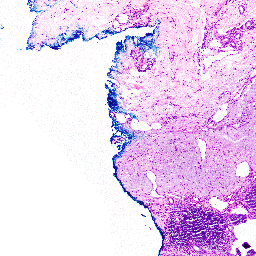

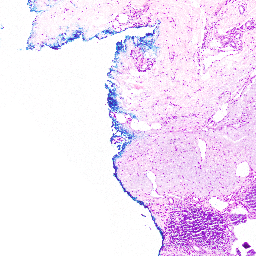

In [ ]:
cv2_imshow(corrected_test_images[7])
cv2_imshow(test_img[7])

In [ ]:
Label_dictionary=[(108,0,115),
                   (145,1,122),
                   (216,47,148),
                   (254,246,242),
                   (181,9,130),
                   (236,85,157),
                   (73,0,106),
                   (248,123,168),
                   (0,0,0),
                   (127,255,255),
                   (127,255,142),
                   (255,127,127)]

In [ ]:


def encode_image(image):
    encode_img = np.full(image.shape[:2], 8, dtype=np.uint8)
    reversed_image = image[:, :, ::-1]

    for k, y in enumerate(Label_dictionary):
        mask = np.all(reversed_image == y, axis=-1)
        encode_img[mask] = k

    return encode_img

In [ ]:
def decode_image(image):
  row,col=image.shape
  decode_img=np.zeros((row,col,3),dtype=np.uint8)
  keys=Lablel_dictionary.keys()
  for i in range():
    for j in range():
      if image[i][j] in keys:
        decode_img[i][j]=Lablel_dictionary[image[i][j]]


  return decode_img




In [ ]:
x=encode_image(train_mask[2])
y=decode_image(train_mask[2])
cv2_imshow(y)

ValueError: ignored

In [ ]:
label_mask_training=[]
for i in range(len(train_mask)):
  encoded_img=encode_image(train_mask[i])
  label_mask_training.append(encoded_img)

In [ ]:
label_mask_testing=[]
for i in range(len(test_mask)):
  encoded_img=encode_image(test_mask[i])
  label_mask_testing.append(encoded_img)

In [ ]:
import tensorflow as tf
from tensorflow import keras
Label_masks_testing = np.array(label_mask_testing)

Label_masks_testing[Label_masks_testing >= 12] = 8

num_classes = 12
test_label_mask = tf.keras.utils.to_categorical(Label_masks_testing, num_classes=12)


In [ ]:
Label_masks_training = np.array(label_mask_training)

Label_masks_training[Label_masks_training >= 12] = 8

num_classes = 12
train_label_mask = tf.keras.utils.to_categorical(Label_masks_training, num_classes=12)


In [ ]:
print(" Training Shape :", train_img.shape, train_label_mask.shape,train_mask.shape)
print(" Testing Shape :", test_img.shape, test_label_mask.shape,test_mask.shape)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

def unet(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bridge
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(32, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(16, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, 3, activation='relu', padding='same')(conv9)

    # Output
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the U-Net model
input_shape = (256, 256, 3)
num_classes = 12
model = unet(input_shape, num_classes)

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
np.array(corrected_train_images).shape

In [ ]:
train_label_mask.shape

In [ ]:
model.fit(np.array(corrected_train_images),train_label_mask,epochs=50,batch_size=40,validation_split=0.2)